# Code

In [1]:
!pip install wfdb
import os
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report,
    average_precision_score, roc_curve
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import wfdb
from google.colab import drive


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 33.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


Configs

In [2]:
# Paths
DRIVE_PATH = '/content/drive/MyDrive/picsdb'
LOCAL_PATH = '/content/picsdb_local'
OUTPUT_DIR = '/content/outputs'

# Data parameters
FS_GRID = 2.0 # Sampling Frequency Grid
WINDOW_LEN = 120.0
HORIZON = 60.0
STRIDE = 15.0  # Stride for negative windows
STRIDE_POSITIVE = 2.5  # Smaller stride for positive windows (more samples)
HR_CLIP_MIN = 40.0
HR_CLIP_MAX = 220.0

# Oversampling
USE_OVERSAMPLING = True  # Balance classes during training
TARGET_POSITIVE_RATIO = 0.4  # Target ~40% positive samples in each batch

# Train/val/test split
TRAIN_INFANTS = ['infant1', 'infant2', 'infant3', 'infant4',
                 'infant5', 'infant6', 'infant7', 'infant8']
VAL_INFANTS = ['infant9']
TEST_INFANTS = ['infant10']

# Model parameters
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
N_EPOCHS = 100
MAX_POS_WEIGHT = 5
PATIENCE = 15  # Early stopping patience
GRAD_CLIP = 1.0


Get data from Google Drive

In [4]:
drive.mount('/content/drive')
shutil.copytree(DRIVE_PATH, LOCAL_PATH)
os.makedirs(OUTPUT_DIR, exist_ok=True)

Mounted at /content/drive


Data Loading functions

In [5]:
def load_hr_series(rec_ecg_rel, base_dir=LOCAL_PATH):
    """Load heart rate time series and bradycardia event times."""
    rec_path = os.path.join(base_dir, rec_ecg_rel)

    header = wfdb.rdheader(rec_path)
    fs = header.fs

    brady_ann = wfdb.rdann(rec_path, 'atr')
    brady_times = np.array(brady_ann.sample) / fs

    r_ann = wfdb.rdann(rec_path, 'qrsc')
    r_times = np.array(r_ann.sample) / fs

    RR = np.diff(r_times)
    hr_times = r_times[1:]
    HR = 60.0 / RR

    return hr_times, HR, brady_times


def load_resp_waveform(rec_ecg_rel, base_dir=LOCAL_PATH):
    """Load respiration waveform."""
    dirname, basename = os.path.split(rec_ecg_rel)
    infant_prefix = basename.split("_")[0]
    resp_basename = infant_prefix + "_resp"
    resp_rel = os.path.join(dirname, resp_basename)
    resp_path = os.path.join(base_dir, resp_rel)

    resp_record = wfdb.rdrecord(resp_path)
    fs_resp = resp_record.fs
    resp_signal = resp_record.p_signal[:, 0]
    t_resp = np.arange(len(resp_signal)) / fs_resp

    return t_resp, resp_signal


def resample_hr_and_resp(hr_times, HR, t_resp, resp_signal):
    """Resample HR and respiration onto common time grid."""
    HR_clip = np.clip(HR, HR_CLIP_MIN, HR_CLIP_MAX)

    t_start = max(hr_times[0], t_resp[0])
    t_end = min(hr_times[-1], t_resp[-1])
    t_grid = np.arange(t_start, t_end, 1.0 / FS_GRID)

    hr_grid = np.interp(t_grid, hr_times, HR_clip)
    resp_grid = np.interp(t_grid, t_resp, resp_signal)

    return t_grid, hr_grid, resp_grid


def make_hr_resp_windows(t_grid, hr_grid, resp_grid, brady_times):
    """Create sliding windows with labels using adaptive stride."""
    brady_times = np.asarray(brady_times)

    L = int(WINDOW_LEN * FS_GRID)
    step_neg = int(STRIDE * FS_GRID)
    step_pos = int(STRIDE_POSITIVE * FS_GRID)
    horizon_steps = int(HORIZON * FS_GRID)

    X, y = [], []
    max_start = len(t_grid) - L - horizon_steps

    # First pass: identify positive windows
    positive_regions = []
    for brady_time in brady_times:
        # A window is positive if its future horizon contains this brady event
        # Window end time + future_start <= brady_time < window_end_time + future_end
        # So: brady_time - HORIZON - WINDOW_LEN <= window_start < brady_time - HORIZON
        start_range_begin = max(0, int((brady_time - HORIZON - WINDOW_LEN) * FS_GRID))
        start_range_end = min(max_start, int((brady_time - HORIZON) * FS_GRID))
        if start_range_end > start_range_begin:
            positive_regions.append((start_range_begin, start_range_end))

    # Merge overlapping regions
    if positive_regions:
        positive_regions.sort()
        merged = [positive_regions[0]]
        for start, end in positive_regions[1:]:
            if start <= merged[-1][1]:
                merged[-1] = (merged[-1][0], max(merged[-1][1], end))
            else:
                merged.append((start, end))
        positive_regions = merged

    # Second pass: sample windows with appropriate stride
    processed_indices = set()

    # Sample positive regions with small stride
    for region_start, region_end in positive_regions:
        for start_idx in range(region_start, region_end, step_pos):
            if start_idx in processed_indices or start_idx > max_start:
                continue

            t_start = t_grid[start_idx]
            t_end = t_start + WINDOW_LEN
            future_start = t_end
            future_end = t_end + HORIZON

            has_brady = np.any((brady_times >= future_start) & (brady_times < future_end))

            hr_win = hr_grid[start_idx:start_idx + L]
            resp_win = resp_grid[start_idx:start_idx + L]
            X.append(np.stack([hr_win, resp_win], axis=0))

            y.append(int(has_brady))
            processed_indices.add(start_idx)

    # Sample negative regions with larger stride
    for start_idx in range(0, max_start, step_neg):
        if start_idx in processed_indices:
            continue

        # Check if this is actually in a positive region
        in_positive_region = any(start <= start_idx < end for start, end in positive_regions)
        if in_positive_region:
            continue

        t_start = t_grid[start_idx]
        t_end = t_start + WINDOW_LEN
        future_start = t_end
        future_end = t_end + HORIZON

        has_brady = np.any((brady_times >= future_start) & (brady_times < future_end))

        hr_win = hr_grid[start_idx:start_idx + L]
        resp_win = resp_grid[start_idx:start_idx + L]
        X.append(np.stack([hr_win, resp_win], axis=0))

        y.append(int(has_brady))

    return np.stack(X), np.array(y, dtype=np.int64)


def process_infant_ecg_resp(rec_ecg_rel):
    """Complete pipeline for one infant."""
    hr_times, HR, brady_times = load_hr_series(rec_ecg_rel)
    t_resp, resp_sig = load_resp_waveform(rec_ecg_rel)
    t_grid, hr_grid, resp_grid = resample_hr_and_resp(hr_times, HR, t_resp, resp_sig)
    X, y = make_hr_resp_windows(t_grid, hr_grid, resp_grid, brady_times)
    return X, y


Process all infants

In [6]:
hea_files = glob.glob(os.path.join(LOCAL_PATH, "**", "*.hea"), recursive=True)
record_names = [os.path.relpath(os.path.splitext(p)[0], LOCAL_PATH) for p in hea_files]
ecg_records = sorted([r for r in record_names if r.endswith("_ecg")])

print(f"Found {len(ecg_records)} ECG records: {ecg_records}")

all_X, all_y, all_infant_ids = [], [], []

for rec in ecg_records:
    X_i, y_i = process_infant_ecg_resp(rec)
    infant_id = os.path.basename(rec).split("_")[0]

    all_X.append(X_i)
    all_y.append(y_i)
    all_infant_ids.append(np.full_like(y_i, infant_id, dtype=object))

    print(f"  Success: {len(y_i)} windows, {y_i.sum()} positive events")

X_all = np.concatenate(all_X, axis=0)
y_all = np.concatenate(all_y, axis=0)
infant_ids = np.concatenate(all_infant_ids, axis=0)

print(f"\n{'='*60}")
print(f"Dataset Summary:")
print(f"{'='*60}")
print(f"Total windows: {X_all.shape[0]}")
print(f"Input shape: {X_all.shape}")
print(f"Positive events: {y_all.sum()} ({100*y_all.mean():.2f}%)")
print(f"Negative events: {(y_all==0).sum()} ({100*(1-y_all.mean()):.2f}%)")
print(f"\nAdaptive Stride Strategy:")
print(f"  Negative windows: stride = {STRIDE}s")
print(f"  Positive windows: stride = {STRIDE_POSITIVE}s (2x more sampling)")

df_summary = pd.DataFrame({"infant": infant_ids, "label": y_all})
print("\nEvents per infant:")
print(df_summary.groupby(["infant", "label"]).size().unstack(fill_value=0))

Found 10 ECG records: ['physionet.org/files/picsdb/1.0.0/infant10_ecg', 'physionet.org/files/picsdb/1.0.0/infant1_ecg', 'physionet.org/files/picsdb/1.0.0/infant2_ecg', 'physionet.org/files/picsdb/1.0.0/infant3_ecg', 'physionet.org/files/picsdb/1.0.0/infant4_ecg', 'physionet.org/files/picsdb/1.0.0/infant5_ecg', 'physionet.org/files/picsdb/1.0.0/infant6_ecg', 'physionet.org/files/picsdb/1.0.0/infant7_ecg', 'physionet.org/files/picsdb/1.0.0/infant8_ecg', 'physionet.org/files/picsdb/1.0.0/infant9_ecg']
  Success: 12418 windows, 231 positive events
  Success: 14016 windows, 1848 positive events
  Success: 13323 windows, 356 positive events
  Success: 13639 windows, 1897 positive events
  Success: 13854 windows, 985 positive events
  Success: 14461 windows, 336 positive events
  Success: 13894 windows, 1345 positive events
  Success: 6227 windows, 476 positive events
  Success: 7013 windows, 672 positive events
  Success: 20744 windows, 2332 positive events

Dataset Summary:
Total windows: 1

Split

In [7]:
train_mask = np.isin(infant_ids, TRAIN_INFANTS)
val_mask = np.isin(infant_ids, VAL_INFANTS)
test_mask = np.isin(infant_ids, TEST_INFANTS)

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val, y_val = X_all[val_mask], y_all[val_mask]
X_test, y_test = X_all[test_mask], y_all[test_mask]

print(f"\n{'='*60}")
print(f"Data Splits:")
print(f"{'='*60}")
print(f"Train: {X_train.shape[0]} windows ({100*y_train.mean():.2f}% positive)")
print(f"Val:   {X_val.shape[0]} windows ({100*y_val.mean():.2f}% positive)")
print(f"Test:  {X_test.shape[0]} windows ({100*y_test.mean():.2f}% positive)")



Data Splits:
Train: 96427 windows (8.21% positive)
Val:   20744 windows (11.24% positive)
Test:  12418 windows (1.86% positive)


Standardization

In [8]:
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

mean_hr = X_train[:, 0, :].mean()
std_hr = X_train[:, 0, :].std()
mean_resp = X_train[:, 1, :].mean()
std_resp = X_train[:, 1, :].std()

std_hr = std_hr if std_hr > 0 else 1.0
std_resp = std_resp if std_resp > 0 else 1.0

print(f"\nStandardization parameters:")
print(f"  HR:   mean={mean_hr:.2f}, std={std_hr:.2f}")
print(f"  Resp: mean={mean_resp:.2f}, std={std_resp:.2f}")

X_train[:, 0, :] = (X_train[:, 0, :] - mean_hr) / std_hr
X_train[:, 1, :] = (X_train[:, 1, :] - mean_resp) / std_resp

X_val[:, 0, :] = (X_val[:, 0, :] - mean_hr) / std_hr
X_val[:, 1, :] = (X_val[:, 1, :] - mean_resp) / std_resp

X_test[:, 0, :] = (X_test[:, 0, :] - mean_hr) / std_hr
X_test[:, 1, :] = (X_test[:, 1, :] - mean_resp) / std_resp


Standardization parameters:
  HR:   mean=143.54, std=19.00
  Resp: mean=19.50, std=7.04


Pytorch Dataset & Dataloader

In [9]:
class HRRespDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = HRRespDataset(X_train, y_train)
val_dataset = HRRespDataset(X_val, y_val)
test_dataset = HRRespDataset(X_test, y_test)

# Create sampler for oversampling positive class
if USE_OVERSAMPLING:
    # Calculate sample weights: positive samples get higher weight
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos

    # Scale weights so positive class appears at target ratio
    desired_ratio = TARGET_POSITIVE_RATIO / (1 - TARGET_POSITIVE_RATIO)
    actual_ratio = n_pos / n_neg
    scale_factor = desired_ratio / actual_ratio

    sample_weights = np.where(y_train == 1, scale_factor, 1.0)
    sampler = torch.utils.data.WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
    print(f"Using oversampling with target positive ratio: {TARGET_POSITIVE_RATIO:.1%}")

    # Diagnostic for distribution: Calculate expected class distribution in sampled batches
    expected_pos = n_pos * scale_factor / (n_pos * scale_factor + n_neg)
    print(f"\nExpected training distribution with oversampling:")
    print(f"  Positive: ~{expected_pos:.1%} (original: {100*n_pos/(n_pos+n_neg):.2f}%)")
    print(f"  Negative: ~{1-expected_pos:.1%}")

else:
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    print("No oversampling - using original class distribution")

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created with batch size {BATCH_SIZE}")

Using oversampling with target positive ratio: 40.0%

Expected training distribution with oversampling:
  Positive: ~40.0% (original: 8.21%)
  Negative: ~60.0%
DataLoaders created with batch size 256


Model Definition

In [10]:
class CNNGRUModel(nn.Module):
    """CNN-GRU model for bradycardia prediction."""

    def __init__(self, n_channels=2, conv_channels=(32, 64),
                 gru_hidden_size=64, gru_num_layers=1, dropout_p=0.5):
        super().__init__()

        c1, c2 = conv_channels

        self.cnn = nn.Sequential(
            nn.Conv1d(n_channels, c1, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(c1, c2, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        self.gru = nn.GRU(
            input_size=c2,
            hidden_size=gru_hidden_size,
            num_layers=gru_num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Sequential(
            nn.Linear(2 * gru_hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        out, h_n = self.gru(x)
        h_last = h_n[-2:, :, :].transpose(0, 1).reshape(x.size(0), -1)
        h_last = self.dropout(h_last)
        logits = self.fc(h_last)
        return logits.squeeze(1)


Training setup

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CNNGRUModel(n_channels=2).to(device)

n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
pos_weight_value = min(n_neg / n_pos, MAX_POS_WEIGHT)

print(f"\nClass distribution:")
print(f"  Positive samples: {n_pos}")
print(f"  Negative samples: {n_neg}")
print(f"  Pos weight: {pos_weight_value:.2f}")

pos_weight = torch.tensor([pos_weight_value], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

Using device: cpu

Class distribution:
  Positive samples: 7915
  Negative samples: 88512
  Pos weight: 5.00


Eval func

In [12]:
def eval_epoch(model, data_loader, criterion, device):
    """Evaluate model on a dataset."""
    model.eval()
    all_labels, all_logits = [], []
    total_loss, n_samples = 0.0, 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            batch_size = y_batch.size(0)
            total_loss += loss.item() * batch_size
            n_samples += batch_size

            all_labels.append(y_batch.cpu().numpy())
            all_logits.append(logits.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_logits = np.concatenate(all_logits)
    probs = 1 / (1 + np.exp(-all_logits))

    try:
        auroc = roc_auc_score(all_labels, probs)
        auprc = average_precision_score(all_labels, probs)
    except ValueError:
        auroc = auprc = float("nan")

    avg_loss = total_loss / n_samples
    return avg_loss, auroc, auprc, all_labels, probs

Training loop

In [13]:
best_val_auroc = -1
best_epoch = 0
patience_counter = 0
history = {'train_loss': [], 'val_loss': [], 'val_auroc': [], 'val_auprc': []}

for epoch in range(1, N_EPOCHS + 1):
    # Training
    model.train()
    total_loss, n_samples = 0.0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)

        optimizer.step()

        batch_size = y_batch.size(0)
        total_loss += loss.item() * batch_size
        n_samples += batch_size

    train_loss = total_loss / n_samples

    # Validation
    val_loss, val_auroc, val_auprc, _, _ = eval_epoch(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_auroc)

    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_auroc'].append(val_auroc)
    history['val_auprc'].append(val_auprc)

    print(f"Epoch {epoch:02d}/{N_EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val AUROC: {val_auroc:.4f} | "
          f"Val AUPRC: {val_auprc:.4f}")

    # Early stopping
    if val_auroc > best_val_auroc:
        best_val_auroc = val_auroc
        best_epoch = epoch
        best_state = model.state_dict().copy()
        patience_counter = 0

        # Save model
        torch.save({
            'epoch': epoch,
            'model_state_dict': best_state,
            'val_auroc': best_val_auroc
        }, os.path.join(OUTPUT_DIR, 'best_model.pth'))

        print(f"  -> New best model (AUROC: {val_auroc:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch}")
            break

# Load best model
model.load_state_dict(best_state)
print(f"\nBest validation AUROC: {best_val_auroc:.4f} (epoch {best_epoch})")

Epoch 01/100 | Train Loss: 1.3445 | Val Loss: 1.0459 | Val AUROC: 0.5289 | Val AUPRC: 0.1093
  -> New best model (AUROC: 0.5289)
Epoch 02/100 | Train Loss: 1.2437 | Val Loss: 0.9867 | Val AUROC: 0.5635 | Val AUPRC: 0.1209
  -> New best model (AUROC: 0.5635)
Epoch 03/100 | Train Loss: 1.2062 | Val Loss: 1.0821 | Val AUROC: 0.5513 | Val AUPRC: 0.1156
Epoch 04/100 | Train Loss: 1.1773 | Val Loss: 1.0687 | Val AUROC: 0.5786 | Val AUPRC: 0.1250
  -> New best model (AUROC: 0.5786)
Epoch 05/100 | Train Loss: 1.1535 | Val Loss: 1.0566 | Val AUROC: 0.5698 | Val AUPRC: 0.1231
Epoch 06/100 | Train Loss: 1.1300 | Val Loss: 1.0189 | Val AUROC: 0.5984 | Val AUPRC: 0.1368
  -> New best model (AUROC: 0.5984)
Epoch 07/100 | Train Loss: 1.0899 | Val Loss: 0.9627 | Val AUROC: 0.6176 | Val AUPRC: 0.1447
  -> New best model (AUROC: 0.6176)
Epoch 08/100 | Train Loss: 1.0568 | Val Loss: 0.9903 | Val AUROC: 0.6155 | Val AUPRC: 0.1442
Epoch 09/100 | Train Loss: 1.0247 | Val Loss: 0.9870 | Val AUROC: 0.6100 | V

Plot training curves

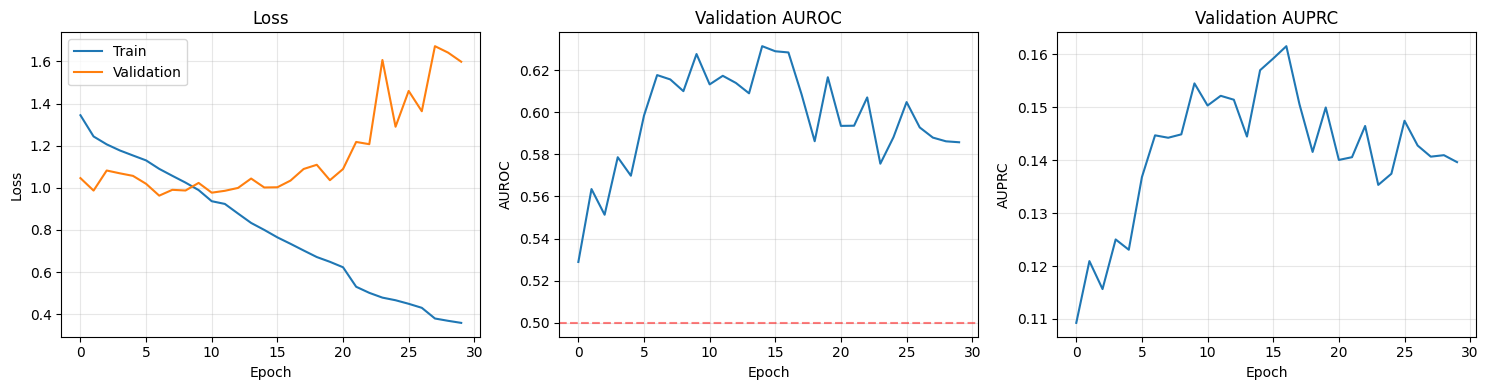

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['val_auroc'])
axes[1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUROC')
axes[1].set_title('Validation AUROC')
axes[1].grid(True, alpha=0.3)

axes[2].plot(history['val_auprc'])
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUPRC')
axes[2].set_title('Validation AUPRC')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves.png'), dpi=150)
plt.show()

Final Eval


Test Loss: 0.4764
Test AUROC: 0.6665
Test AUPRC: 0.0537

Optimal threshold: 0.398

Confusion Matrix:
[[10981  1206]
 [  145    86]]

Classification Report:
              precision    recall  f1-score   support

    No Event      0.987     0.901     0.942     12187
 Bradycardia      0.067     0.372     0.113       231

    accuracy                          0.891     12418
   macro avg      0.527     0.637     0.527     12418
weighted avg      0.970     0.891     0.927     12418



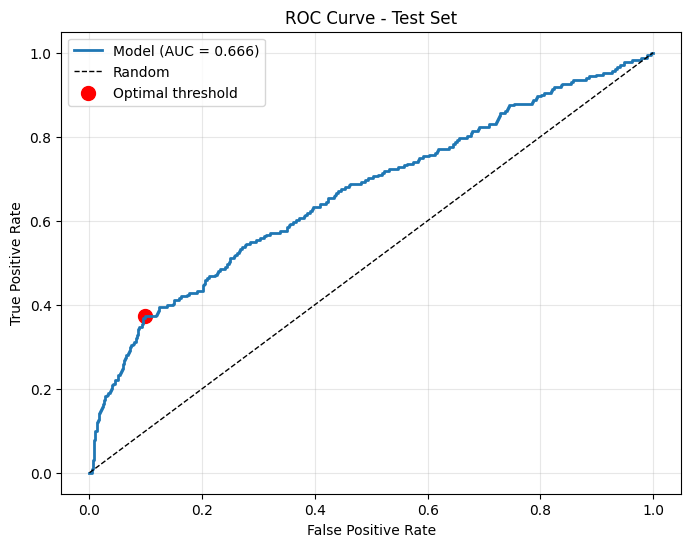


Model saved to: /content/outputs/best_model.pth
Plots saved to: /content/outputs/


In [16]:
test_loss, test_auroc, test_auprc, test_labels, test_probs = eval_epoch(
    model, test_loader, criterion, device
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test AUROC: {test_auroc:.4f}")
print(f"Test AUPRC: {test_auprc:.4f}")

# Find optimal threshold
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nOptimal threshold: {optimal_threshold:.3f}")

# Predictions
test_preds = (test_probs >= optimal_threshold).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, test_preds))

print("\nClassification Report:")
print(classification_report(test_labels, test_preds,
                           target_names=['No Event', 'Bradycardia'],
                           digits=3))

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'Model (AUC = {test_auroc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
plt.scatter([fpr[optimal_idx]], [tpr[optimal_idx]], s=100, c='red',
            marker='o', label=f'Optimal threshold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(OUTPUT_DIR, 'roc_curve.png'), dpi=150)
plt.show()

print(f"\nModel saved to: {OUTPUT_DIR}/best_model.pth")
print(f"Plots saved to: {OUTPUT_DIR}/")

# AI usage disclosure:

I used the following LLMs:
* ChatGPT 5.1
* Gemini 3.0
* Sonnet 4.5

For the following tasks:
* brainstorming & planning
* debugging/error explainations
* feedback & suggestions for improving code
* improveing readability (refactoring, commenting, etc.)